# Homework 2. Machine Translation



**Deadline:** 18.11.2024 23:59 EET

**Submission rules:** Sumbissions are through the [courses page](https://courses.cs.ut.ee/). For this homework, submit:

1. this notebook with:
    1. full code, outputs, and answers for part 1;
    2. answers for part 2;
2. for part 2, all the scripts you used for preprocessing, training and translation. (Please give your scripts descriptive names, e.g. `cleaning.py`, `01_cleaning.sh`, `02_sentencepiece.sh`, and not `myscript.sh`);
3. the translated test sets (task 6).

**Hint.** You can get files from Rocket by using `scp` or, for example, by downloading them from jupyter lab environment (https://jupyter.hpc.ut.ee).

**!Do not forget to make a copy of this notebook before starting doing the homework!**

**START IN ADVANCE.** Training the model for task 5 may take several hours. There might be queues for the GPUs on Rocket as well, and waiting for your job to start might take much longer than the training itself. Leave yourself some room for error. You might want to use email notifications (`#SBATCH --mail-type=ALL` and `#SBATCH --mail-user=your@email` in your SLURM script; if you don't know what this means, see the guide at the beginning of part 2 of this homework). Then you will have more chance to notice if your job fails.

If you feel lost, review the materials of labs 1, 4, and 5, and look into Fairseq's documentation. Feel free to ask a question in Slack (channel `#hw`) if something remains unclear.

In this homework, we are mostly going back to using existing packages and tools, but will also do some manual data analysis. The homework consists of two parts:

1. In part 1, we will pay some extra attention to parallel corpora and their pre-processing.
2. In part 2, we will do one full cycle of creating a sequence-to-sequence model for machine translation, starting from downloading data and up to evaluation of the trained model's outputs.

## Part 1. Data

**Note:** Part 1 can be easily done in Colab. Make a copy of this notebook and submit your answers with it.

### Task 1. Examining data (1 pt)

In this task, we will use the OpenSubtitles corpus, which is comprised of movie and TV subtitles.

First, download the OpenSubtitles corpus. Choose a language pair where one language is English and another is some language that you know. Download the corpus fom here: https://opus.nlpl.eu/OpenSubtitles/corpus/version/OpenSubtitles. After specifying the language pair, download the latest bilingual *moses* (uncleaned) version of the dataset. The files you will need are `OpenSubtitles.*.en` and `OpenSubtitles.*.<lang>`, where `<lang>` is the language you picked. These are parallel files where sources and targets are aligned.

**Question.** Which language pair did you choose?

**Your answer here:** Ukrainian

**Task.** Real data is always messy, and it is important to look at your data and know what is there. Print out 10 **randomly selected** sentence pairs from the corpus in a readable format. How many of these 10 pairs are good translations of each other, how many are acceptable, how many are bad? Describe what kind of mismatches you see. Are there any repeating patterns?

In [1]:
#### TODO BEGIN ####
dataset_url = "https://object.pouta.csc.fi/OPUS-CCMatrix/v1/moses/en-uk.txt.zip"
!wget $dataset_url
!unzip en-uk.txt.zip



--2024-11-14 20:02:05--  https://object.pouta.csc.fi/OPUS-CCMatrix/v1/moses/en-uk.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1727045236 (1.6G) [application/zip]
Saving to: ‘en-uk.txt.zip’

en-uk.txt.zip       100%[===================>]   1.61G  25.1MB/s    in 63s     

2024-11-14 20:03:09 (26.2 MB/s) - ‘en-uk.txt.zip’ saved [1727045236/1727045236]

Archive:  en-uk.txt.zip
  inflating: README                  
  inflating: LICENSE                 
  inflating: CCMatrix.en-uk.en       
  inflating: CCMatrix.en-uk.uk       
  inflating: CCMatrix.en-uk.scores   


In [1]:
with open('/content/CCMatrix.en-uk.uk', 'r') as f:
    uk_lines = f.readlines()

with open('/content/CCMatrix.en-uk.en', 'r') as f:
    en_lines = f.readlines()

pairs = list(zip(uk_lines, en_lines))


In [2]:
uk_lines= []
en_lines = []

In [3]:
import random
random_lines = random.sample(pairs, 10)
for line in random_lines:
    print(line)

('У волинському місті не хлоруватимуть воду\n', 'Not chlorinated city water.\n')
('Ніщо не шкодить тому, в кому перебуває Бог.\n', 'There is nobody that God is indebted to.\n')
("В Айдаго-Фоллс розташований офіс Об'єднання виробників картоплі Айдахо та управління 7 округу Департаменту Охорони Здоров'я та Добробуту.\n", 'Idaho Falls hosts the headquarters of the United Potato Growers of Idaho and District 7 of the Idaho Department of Health and Welfare.\n')
('Ми мали широкомасштабну визначальну перемогу в електоральному коледжі».\n', 'We had a large institutional win in California.”\n')
('15 квітня протестуючі блокували площу Франції в Єревані і перекрили вулицю Абовян, де розпочали сидячий страйк.\n', 'April 15 – The protesters blocked the French Square in Yerevan and blocked Abovyan Street, where they began a sit-in strike.\n')
('Індикатором, успішного лікування є зникнення білої плівки.\n', 'The indicator, successful treatment is the disappearance of the white film.\n')
('Тепер молоч

In [4]:
print(len(pairs))

20240171


In [5]:
pairs = pairs[:5000000]

In [ ]:
#### TODO END ####

How many of these 10 pairs are good translations of each other, how many are acceptable, how many are bad? Describe what kind of mismatches you see. Are there any repeating patterns?

**Your answer:** 

Around a half of the sentences are translated bad, especially in the cases when one of the sentenses has more context which is not directly translatable.
There is a trend, that in Ukrainian the same sentense provides more information even if there are the similar or related words used for English version.

Otherwise, 2 can be acceptable and 3 are really good. 

Sometimes, even when some words are a direct translation of each other, they can bring different information based on the context they are in. In this translation it happened for too many times, to consider it as good enough.

### Task 2. Cleaning (1.5 pt)

During the lab, we applied a few simple cleaning steps to our training corpus. In this task, you will try something slightly more sophisticated.

**Task.** Propose one more simple cleaning procedure for a parallel corpus. Your heuristic does not have to solve all our problems and remove all bad sentence pairs. It also does not have to have 0 false positive rate (if it might also remove some good sentence pairs, that's okay). It just has to be lightweight (no solutions involving neural networks) and intuitively seem like it would detect some bad translations.

**Hint.** If you are stuck, try downloading the OpenSubtitles corpus in English and some language that you **don't** know. Look at some random sentence pairs. How do you guess if a pair is good or bad? Can you formalize it?

**Your answer:** I want to make an additional exploration of the data to clean it based on the lenght rartios, and to remove too long or too short sentences in the dataset.

**Task.** Implement your idea. Apply your code to the OpenSubtitles corpus (if the corpus in the language pair of your choice is very big, you can process a subset of it). Did it work? If it did, bring some examples of bad sentence pairs that it removed.

Summary Statistics:
       English Length  Ukrainian Length  English Word Count  \
count     5000.000000       5000.000000         5000.000000   
mean        57.699600         57.024400           10.933600   
std         23.805266         24.116843            4.525007   
min         13.000000         10.000000            2.000000   
25%         41.000000         40.000000            8.000000   
50%         53.000000         53.000000           10.000000   
75%         70.000000         69.000000           13.000000   
max        216.000000        243.000000           37.000000   

       Ukrainian Word Count  Length Ratio  
count           5000.000000   5000.000000  
mean               9.517000      1.041713  
std                4.085566      0.241149  
min                2.000000      0.397959  
25%                7.000000      0.878049  
50%                9.000000      1.018868  
75%               12.000000      1.184211  
max               35.000000      2.323944  


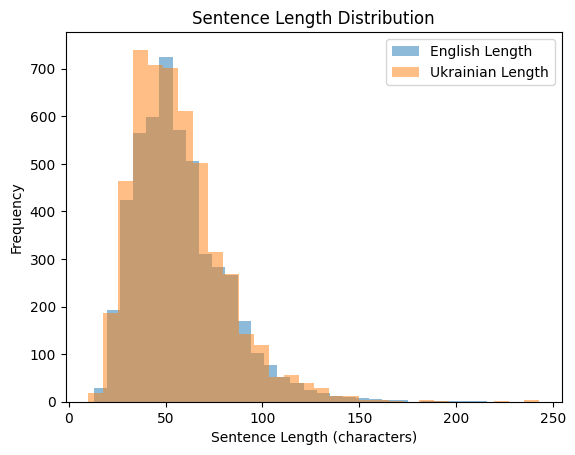

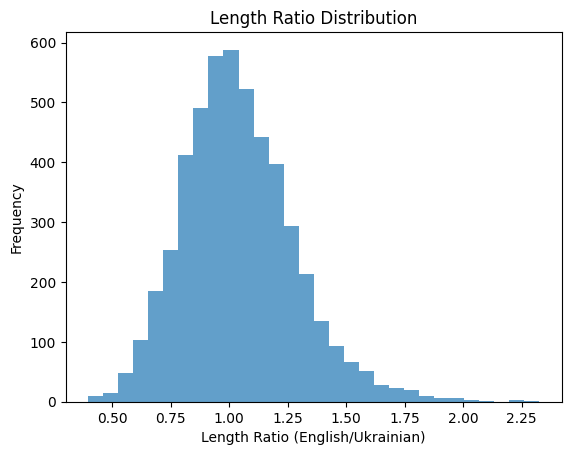

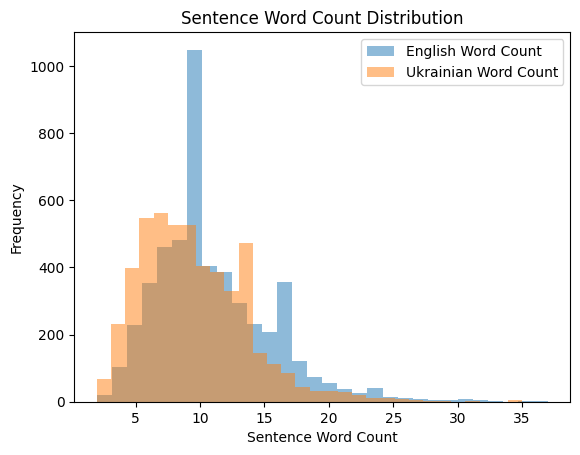


Most Common English Words: [('the', 2794), ('of', 1433), ('and', 1397), ('is', 1327), ('to', 1237), ('God’s', 883), ('you', 718), ('will', 703), ('in', 695), ('not', 581)]
Most Common Ukrainian Words: [('і', 1034), ('не', 910), ('що', 666), ('в', 541), ('на', 458), ('з', 457), ('–', 342), ('у', 335), ('до', 320), ('Він', 317)]


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np

def exploratory_analysis(pairs):
    en_lengths = []
    uk_lengths = []
    en_word_counts = []
    uk_word_counts = []

    for uk, en in pairs:
        en, uk = en.strip(), uk.strip()
        en_lengths.append(len(en))
        uk_lengths.append(len(uk))

        en_word_counts.append(len(en.split()))
        uk_word_counts.append(len(uk.split()))

    df = pd.DataFrame({
        'English Length': en_lengths,
        'Ukrainian Length': uk_lengths,
        'English Word Count': en_word_counts,
        'Ukrainian Word Count': uk_word_counts,
    })
    df['Length Ratio'] = df['English Length'] / df['Ukrainian Length']

    print("Summary Statistics:")
    print(df.describe())

    plt.figure()
    plt.hist(df['English Length'], bins=30, alpha=0.5, label='English Length')
    plt.hist(df['Ukrainian Length'], bins=30, alpha=0.5, label='Ukrainian Length')
    plt.xlabel('Sentence Length (characters)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Sentence Length Distribution')
    plt.show()

    plt.figure()
    plt.hist(df['Length Ratio'].dropna(), bins=30, alpha=0.7)
    plt.xlabel('Length Ratio (English/Ukrainian)')
    plt.ylabel('Frequency')
    plt.title('Length Ratio Distribution')
    plt.show()

    plt.figure()
    plt.hist(df['English Word Count'], bins=30, alpha=0.5, label='English Word Count')
    plt.hist(df['Ukrainian Word Count'], bins=30, alpha=0.5, label='Ukrainian Word Count')
    plt.xlabel('Sentence Word Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Sentence Word Count Distribution')
    plt.show()

    en_words = Counter(" ".join([en for _ , en in pairs]).split()).most_common(10)
    uk_words = Counter(" ".join([uk for uk, _ in pairs]).split()).most_common(10)

    print("\nMost Common English Words:", en_words)
    print("Most Common Ukrainian Words:", uk_words)

exploratory_analysis(pairs[:5000])


In [12]:
#### TODO BEGIN ####
def clean_parallel_corpus(pairs, length_ratio_min=0.7, length_ratio_max=1.3,
                          min_length=15, max_length=150, max_word_diff=15):
    cleaned_pairs = []
    for uk, en in pairs:
        en, uk = en.strip(), uk.strip()
        en_length, uk_length = len(en), len(uk)
        en_word_count, uk_word_count = len(en.split()), len(uk.split())
        length_ratio = en_length / uk_length if uk_length > 0 else 0

        if (min_length <= en_length <= max_length and
            min_length <= uk_length <= max_length and
            length_ratio_min <= length_ratio <= length_ratio_max and
            abs(en_word_count - uk_word_count) <= max_word_diff):

            cleaned_pairs.append((uk, en))

    return cleaned_pairs

#### TODO END ####

In [13]:
sample_pairs = pairs
cleaned_pairs = clean_parallel_corpus(sample_pairs)

print("Number of cleaned pairs:", len(cleaned_pairs))
for pair in cleaned_pairs[:10]:
    print(pair)

Number of cleaned pairs: 3528193
('ви вже народ дістали своєю брехнею', '[6] For thou hast rejected thy people,')
('Говори їм, що робити - і вони здивують тебе своєю винахідливістю".', "Tell them what to do, and they'll surprise you with their ingenuity.”")
('Аллах — Прощаючий, Милостивий! (25:68-70)', 'And Allah is Ever Oft\xadForgiving, Most Merciful.')
('Нострадамус сказав, що “багаті помруть багато разів”.', 'Nostradamus said: “the rich would die many times over.”')
('Нострадамус сказав, що "багаті помруть багато разів".', 'Nostradamus said: “the rich would die many times over.”')
('Просіть у Аллага прощення, адже Він Прощаючий, Милосердний.', 'Truly, Allah forgives all sins; He is Oft-Forgiving, Most Merciful.')
('Та хто ж більший нечестивець, ніж той, хто зводить наклеп на Аллаха, коли його закликають до ісламу!', 'Who does greater wrong than he who invents falsehood against Allah, when he is called to Islam?')
('Це буде на Господню славу, на вічний пам’ятник, який не буде знищен

**Your answer:** In general, most of the cleaned pairs in the random subset appeared to be well translated, but it can also depend too much on which pairs were choen exactly at this run. Hopefully, my cleaning removed the pairs which are definitely not fitting for my training process.

### Task 3. Corpus statistics (1.5 pt)

In the lab, we have used the length ratios of source and target sentences to filter out some bad sentence pairs. However, we cannot always expect the ratio to be close to 1. All languages are different, and some use more words than others to express the same meaning.

In this task you will examine some corpus statistics. Let us look in more detail at a language pair that we will be dealing with futher on in this homework: Estonian $\leftrightarrow$ English. We will work with the Europarl corpus that we used in lab 5.

**Task.** Take the Estonian $\leftrightarrow$ English Europarl corpus. Calculate how many tokens there are in the English side and in the Estonian side. (Tokenize the text beforehand. You can use any tokenizer: `mosestokenizer`, `spaCy`, or anything else.) Calculate how many **distinct** tokens (word types) there are in the English and in the Estonian side.

In [14]:
!mkdir data
!wget -P data https://object.pouta.csc.fi/OPUS-Europarl/v8/moses/en-et.txt.zip
!unzip data/en-et.txt.zip -d data

--2024-11-14 20:34:46--  https://object.pouta.csc.fi/OPUS-Europarl/v8/moses/en-et.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61592035 (59M) [application/zip]
Saving to: ‘data/en-et.txt.zip’

en-et.txt.zip       100%[===================>]  58.74M  7.81MB/s    in 7.5s    

2024-11-14 20:34:55 (7.81 MB/s) - ‘data/en-et.txt.zip’ saved [61592035/61592035]

Archive:  data/en-et.txt.zip
  inflating: data/README             
  inflating: data/LICENSE            
  inflating: data/Europarl.en-et.en  
  inflating: data/Europarl.en-et.et  
  inflating: data/Europarl.en-et.xml  


In [15]:
#### TODO BEGIN ####
with open('data/Europarl.en-et.en', 'r', encoding='utf-8') as file_en, \
     open('data/Europarl.en-et.et', 'r', encoding='utf-8') as file_et:

    en_lines = file_en.readlines()
    et_lines = file_et.readlines()

    print('Number of lines in English:', len(en_lines))
    print('Number of lines in Estonian:', len(et_lines))
#### TODO END ####

Number of lines in English: 651236
Number of lines in Estonian: 651236


In [16]:
!pip install mosestokenizer


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for mosestokenizer: filename=mosestokenizer-1.2.1-py3-none-any.whl size=49171 sha256=0e281fe8852a0c8c6008dab17acbb5d6190314be6db267340066b2ce3a9e0c9e
  Stored in directory: /root/.cache/pip/wheels/80/d8/15/4c5ebbe883513f003cb055a0369c77c9df857023a706f39e70
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6966e9471a7822a9947910838e9eda67b457baf13afc44091614cbf4a6b2360c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for toolwrapper: filename=toolwrapper-2.1.0-py3-none-any.whl size=3338 sha256=fb2ed47df8de63010538afdfc19262e1de8e7ae9739b6e116d7eadb45c89bcff
  Stored in directory: /root/.cache/pip/wheels/e1/af/b1/99b57a06dda78fdcee86d2e22c64743f3b8df8f31cfc04baf7
  Created wheel for uctools: filenam

In [23]:
from mosestokenizer import MosesTokenizer
import matplotlib.pyplot as plt

def calculate_sentence_lengths_moses(lines, language):
    sentence_lengths = []
    with MosesTokenizer(language) as tokenizer:
        for line in lines:
            tokens = tokenizer(line.strip().lower())
            sentence_lengths.append(len(tokens))
    return sentence_lengths

with open('data/Europarl.en-et.en', 'r', encoding='utf-8') as file_en, \
     open('data/Europarl.en-et.et', 'r', encoding='utf-8') as file_et:

    en_lines = file_en.readlines()
    et_lines = file_et.readlines()

en_sentence_lengths = calculate_sentence_lengths_moses(en_lines[:50000], 'en')
et_sentence_lengths = calculate_sentence_lengths_moses(et_lines[:50000], 'et')

In [24]:
print("English Sentence Lengths:")
print("Minimum:", min(en_sentence_lengths))
print("Maximum:", max(en_sentence_lengths))
print("Average:", sum(en_sentence_lengths) / len(en_sentence_lengths))

print("\nEstonian Sentence Lengths:")
print("Minimum:", min(et_sentence_lengths))
print("Maximum:", max(et_sentence_lengths))
print("Average:", sum(et_sentence_lengths) / len(et_sentence_lengths))

English Sentence Lengths:
Minimum: 1
Maximum: 214
Average: 26.16844

Estonian Sentence Lengths:
Minimum: 1
Maximum: 122
Average: 19.62808


**Task.** Plot the distribution of sentence lengths (measured in tokens) in the English and the Estonian side of the corpus. Compare the distributions.

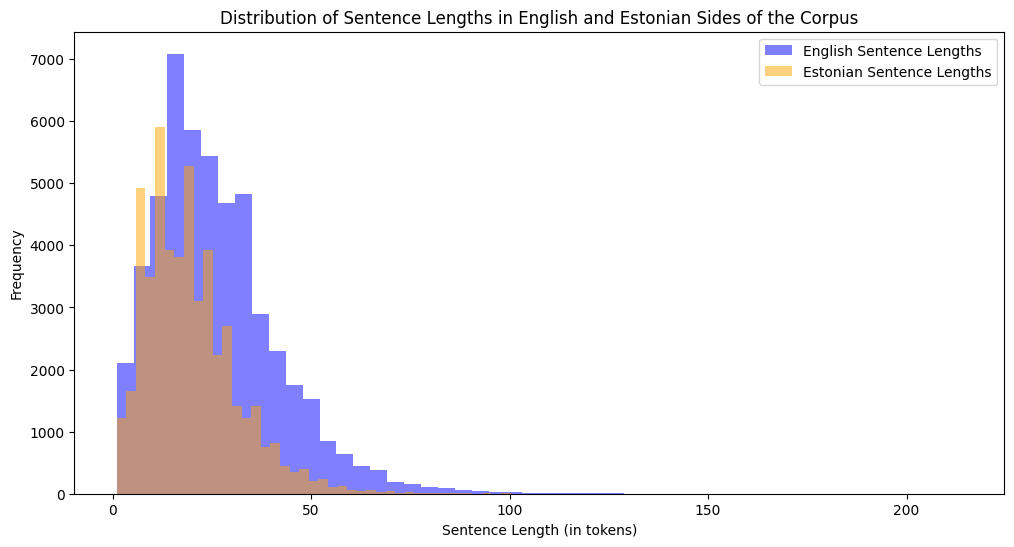

In [25]:
#### TODO BEGIN ####
plt.figure(figsize=(12, 6))

plt.hist(en_sentence_lengths, bins=50, alpha=0.5, label='English Sentence Lengths', color='blue')
plt.hist(et_sentence_lengths, bins=50, alpha=0.5, label='Estonian Sentence Lengths', color='orange')

plt.xlabel('Sentence Length (in tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in English and Estonian Sides of the Corpus')
plt.legend()
plt.show()
#### TODO END ####

**Question.** What can you say about the difference between English and Estonian languages based on the numbers and the plots?

**Your answer:** 

- Most sentences in both languages are short, clustered between 5 to 30 tokens.

- English sentences are a bit longer on average compared to Estonian sentences, English histogram shows more sentences with greater lengths, while Estonian has fewer.

- There are very few sentences exceeding 100 tokens, but this is more common in English than Estonian.


## Part 2. Training an Estonian $\rightarrow$ English translation model

**Note:** Part 2 requires creating some models that will take a while to train. You should use GPUs on the Tartu University's High Performance Computing Center servers to do part 2. You have been added as users of the Rocket cluster, which you can access with your UT username and password. For those who are not familiar with Rocket (or working on remote servers in general), we have prepared [a beginner's guide](https://courses.cs.ut.ee/2023/transformers23/fall/Main/Labs?action=download&upname=hpc_guide.pdf). We suggest you read it and do the tasks from it before doing part 2 of the homework.

**Please be reasonable when using resources on Rocket.**

In part 2 of this homework, we will train an actual machine translation model. In this part, you will create several scripts for the steps of the process. Don't forget to give your scripts **descriptive names** and refer to the submission rules described above when preparing the files for submission.

### Task 4. Preprocessing (2 pt)

1. **Download the data.** Go to http://opus.nlpl.eu/. You will need 4 corpora:  OpenSubtitles, Europarl, JRC-Acquis, and EMEA. Download all four corpora for English-Estonian.
2. Clean the data.
  1. Apply basic cleaning as in lab 5.
  2. Optionally, you can also apply your own cleaning procedures you came up with in task 2.
3. **Take a subset of the data.** Randomly select 1,500,000 sentence pairs from OpenSubtitles, and 500,000 from each of Europarl, JRC-Acquis, and EMEA (if not using OpusFilter, do not forget that parallel lines have to remain parallel when you shuffle them). Concatenate the corpora.
4. Separate a randomly chosen development set of **2,000** sentence pairs and a test set of **2,000** sentence pairs, all remaining sentence pairs go into the training set. (Sentence pairs from all 4 corpora should be present in the development and test sets.)
5. Optionally, train a truecasing model and apply it.
6. Train a SentencePiece model and apply it. The vocabulary size should be **32,000** units, **shared** between source and target sides (you need to train just one SentencePiece model, not two).

Note that you should only use the **training set** to train your truecasing (if using) and SentencePiece models.

In [1]:
import os
import urllib.request
import zipfile


dataset_urls = {
    "Europarl": "https://object.pouta.csc.fi/OPUS-Europarl/v8/moses/en-et.txt.zip",
    "OpenSubtitles": "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-et.txt.zip",
    "JRC-Acquis": "https://object.pouta.csc.fi/OPUS-JRC-Acquis/v3.0/moses/en-et.txt.zip",
    "EMEA": "https://object.pouta.csc.fi/OPUS-EMEA/v3/moses/en-et.txt.zip"
}

main_folder = "data_task_2"
os.makedirs(main_folder, exist_ok=True)

def download_and_unzip(name, url):
    zip_path = os.path.join(main_folder, f"{name}.zip")
    extract_folder = os.path.join(main_folder, name)

    print(f"Downloading {name}...")
    urllib.request.urlretrieve(url, zip_path)

    print(f"Unzipping {name}...")
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

    os.remove(zip_path)
    print(f"{name} downloaded and extracted.\n")

for name, url in dataset_urls.items():
    download_and_unzip(name, url)

print("All datasets downloaded and extracted successfully.")


Unzipping Europarl...
Europarl downloaded and extracted.

Unzipping OpenSubtitles...
OpenSubtitles downloaded and extracted.

Unzipping JRC-Acquis...
JRC-Acquis downloaded and extracted.

Unzipping EMEA...
EMEA downloaded and extracted.

All datasets downloaded and extracted successfully.


In [2]:
import os
import random

datasets = {
    "Europarl": "data_task_2/Europarl/Europarl.en-et",
    "OpenSubtitles": "data_task_2/OpenSubtitles/OpenSubtitles.en-et",
    "JRC-Acquis": "data_task_2/JRC-Acquis/JRC-Acquis.en-et",
    "EMEA": "data_task_2/EMEA/EMEA.en-et"
}


def deduplicate(list1, list2):
    unique = []
    repeated = set()
    pairs = zip(list1, list2)

    for pair in pairs:
        if pair in repeated:
            continue
        else:
            unique.append(pair)
            repeated.add(pair)

    return [entry[0] for entry in unique], [entry[1] for entry in unique]

def length_filter(list1, list2, min_length=3, max_length=100):
    res1, res2 = [], []
    words1 = [sent.split() for sent in list1]
    words2 = [sent.split() for sent in list2]

    for sent1, sent2 in zip(words1, words2):
        if min_length <= len(sent1) <= max_length and min_length <= len(sent2) <= max_length:
            res1.append(' '.join(sent1))
            res2.append(' '.join(sent2))

    return res1, res2

def length_ratio_filter(list1, list2, ratio=3):
    res1, res2 = [], []

    for sent1, sent2 in zip(list1, list2):
        if (1 / ratio) <= len(sent1) / len(sent2) <= ratio:
            res1.append(sent1)
            res2.append(sent2)

    return res1, res2

In [3]:
def process_dataset(dataset_name, dataset_path):
    print(f"Processing {dataset_name} dataset...")
    with open(f"{dataset_path}.en", 'r', encoding='utf-8') as file_en, \
         open(f"{dataset_path}.et", 'r', encoding='utf-8') as file_et:

        en_lines = file_en.readlines()
        et_lines = file_et.readlines()

    print(f"\nProcessing {dataset_name} dataset:")
    print('Initial number of lines:', len(en_lines))

    en_filtered, et_filtered = deduplicate(en_lines, et_lines)
    print('Lines after deduplication:', len(en_filtered))

    en_filtered, et_filtered = length_filter(en_filtered, et_filtered, min_length=3, max_length=100)
    print('Lines after length filtering:', len(en_filtered))

    en_filtered, et_filtered = length_ratio_filter(en_filtered, et_filtered, ratio=3)
    print('Lines after length ratio filtering:', len(en_filtered))

    os.makedirs("cleaned_data", exist_ok=True)
    with open(f"cleaned_data/{dataset_name}.cleaned.en", 'w', encoding='utf-8') as file_en, \
         open(f"cleaned_data/{dataset_name}.cleaned.et", 'w', encoding='utf-8') as file_et:

        file_en.writelines([line + '\n' for line in en_filtered])
        file_et.writelines([line + '\n' for line in et_filtered])

    print(f"Cleaned {dataset_name} dataset saved")


In [4]:
process_dataset("Europarl", datasets["Europarl"])

Processing Europarl dataset...

Processing Europarl dataset:
Initial number of lines: 651236
Lines after deduplication: 632152
Lines after length filtering: 629587
Lines after length ratio filtering: 629345
Cleaned Europarl dataset saved


In [5]:
process_dataset("OpenSubtitles", datasets["OpenSubtitles"])

Processing OpenSubtitles dataset...

Processing OpenSubtitles dataset:
Initial number of lines: 12486898
Lines after deduplication: 10251072
Lines after length filtering: 8596567
Lines after length ratio filtering: 8560447
Cleaned OpenSubtitles dataset saved


In [6]:
process_dataset("JRC-Acquis", datasets["JRC-Acquis"])

Processing JRC-Acquis dataset...

Processing JRC-Acquis dataset:
Initial number of lines: 781770
Lines after deduplication: 485723
Lines after length filtering: 460522
Lines after length ratio filtering: 459447
Cleaned JRC-Acquis dataset saved


In [7]:
process_dataset("EMEA", datasets["EMEA"])

Processing EMEA dataset...

Processing EMEA dataset:
Initial number of lines: 1021442
Lines after deduplication: 333780
Lines after length filtering: 285535
Lines after length ratio filtering: 277275
Cleaned EMEA dataset saved


In [8]:
import random

cleaned_datasets = {
    "OpenSubtitles": ("cleaned_data/OpenSubtitles.cleaned.en", "cleaned_data/OpenSubtitles.cleaned.et"),
    "Europarl": ("cleaned_data/Europarl.cleaned.en", "cleaned_data/Europarl.cleaned.et"),
    "JRC-Acquis": ("cleaned_data/JRC-Acquis.cleaned.en", "cleaned_data/JRC-Acquis.cleaned.et"),
    "EMEA": ("cleaned_data/EMEA.cleaned.en", "cleaned_data/EMEA.cleaned.et")
}

sample_sizes = {
    "OpenSubtitles": 1500000,
    "Europarl": 500000,
    "JRC-Acquis": 500000,
    "EMEA": 500000
}


In [9]:

def load_and_sample(file_en, file_et, sample_size):
    with open(file_en, 'r', encoding='utf-8') as f_en, \
         open(file_et, 'r', encoding='utf-8') as f_et:

        en_lines = f_en.readlines()
        et_lines = f_et.readlines()

    assert len(en_lines) == len(et_lines), "Mismatch in number of lines between English and Estonian files."

    pairs = list(zip(en_lines, et_lines))
    sampled_pairs = random.sample(pairs, min(sample_size, len(pairs)))

    sampled_en, sampled_et = zip(*sampled_pairs)
    return list(sampled_en), list(sampled_et)

In [10]:
all_en, all_et = [], []

for dataset_name, (file_en, file_et) in cleaned_datasets.items():
    sample_size = sample_sizes[dataset_name]
    print(f"Sampling {sample_size} pairs from {dataset_name}...")

    sampled_en, sampled_et = load_and_sample(file_en, file_et, sample_size)
    all_en.extend(sampled_en)
    all_et.extend(sampled_et)

combined_pairs = list(zip(all_en, all_et))
random.shuffle(combined_pairs)

final_en, final_et = zip(*combined_pairs)

with open("cleaned_data/combined_dataset.en", 'w', encoding='utf-8') as f_en, \
     open("cleaned_data/combined_dataset.et", 'w', encoding='utf-8') as f_et:

    f_en.writelines(final_en)
    f_et.writelines(final_et)

Sampling 1500000 pairs from OpenSubtitles...
Sampling 500000 pairs from Europarl...
Sampling 500000 pairs from JRC-Acquis...
Sampling 500000 pairs from EMEA...


In [11]:
import random
with open("cleaned_data/combined_dataset.en", 'r', encoding='utf-8') as f_en, \
     open("cleaned_data/combined_dataset.et", 'r', encoding='utf-8') as f_et:
    
    all_en = f_en.readlines()
    all_et = f_et.readlines()

all_pairs = list(zip(all_en, all_et))


random.shuffle(all_pairs)

In [12]:
dev_set = all_pairs[:2000]
test_set = all_pairs[2000:4000]
train_set = all_pairs[4000:]

dev_en, dev_et = zip(*dev_set)
test_en, test_et = zip(*test_set)
train_en, train_et = zip(*train_set)

In [13]:
with open("cleaned_data/train.en", 'w', encoding='utf-8') as f_train_en, \
     open("cleaned_data/train.et", 'w', encoding='utf-8') as f_train_et:
    
    f_train_en.writelines(train_en)
    f_train_et.writelines(train_et)

with open("cleaned_data/dev.en", 'w', encoding='utf-8') as f_dev_en, \
     open("cleaned_data/dev.et", 'w', encoding='utf-8') as f_dev_et:
    
    f_dev_en.writelines(dev_en)
    f_dev_et.writelines(dev_et)

with open("cleaned_data/test.en", 'w', encoding='utf-8') as f_test_en, \
     open("cleaned_data/test.et", 'w', encoding='utf-8') as f_test_et:
    
    f_test_en.writelines(test_en)
    f_test_et.writelines(test_et)

In [15]:
!pip install sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.6 MB/s eta 0:00:00a 0:00:01


In [16]:
with open("cleaned_data/train.en", "r", encoding="utf-8") as f_en, \
     open("cleaned_data/train.et", "r", encoding="utf-8") as f_et, \
     open("cleaned_data/train_combined.txt", "w", encoding="utf-8") as f_combined:
    
    for en_line, et_line in zip(f_en, f_et):
        f_combined.write(en_line.strip() + "\n")
        f_combined.write(et_line.strip() + "\n")


In [17]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    input="cleaned_data/train_combined.txt",   
    model_prefix="sentencepiece",              
    vocab_size=32000,                          
    model_type="bpe",                          
    character_coverage=1.0
)

In [4]:
import sentencepiece as spm
# Train the SentencePiece model with a timer
spm.SentencePieceTrainer.train(
    input="cleaned_data/train_combined.txt",   # Use the sampled input file
    model_prefix="sentencepiece",              
    vocab_size=32000,                          
    model_type="bpe",                          
    character_coverage=1.0,
    input_sentence_size=20000,
    num_threads=4,                   # Multi-threading
    shuffle_input_sentence=True,     # Shuffle for diversity
    hard_vocab_limit=False           # Disable hard vocabulary limit
)

In [5]:
sp = spm.SentencePieceProcessor(model_file="sentencepiece.model")
def apply_sentencepiece(data, sp_model):
    return [" ".join(sp_model.encode(line.strip(), out_type=str)) + "\n" for line in data]

In [6]:
with open("cleaned_data/train.en", "r", encoding="utf-8") as f_train_en, \
     open("cleaned_data/train.et", "r", encoding="utf-8") as f_train_et, \
     open("cleaned_data/dev.en", "r", encoding="utf-8") as f_dev_en, \
     open("cleaned_data/dev.et", "r", encoding="utf-8") as f_dev_et, \
     open("cleaned_data/test.en", "r", encoding="utf-8") as f_test_en, \
     open("cleaned_data/test.et", "r", encoding="utf-8") as f_test_et:
    
    train_en = f_train_en.readlines()
    train_et = f_train_et.readlines()
    dev_en = f_dev_en.readlines()
    dev_et = f_dev_et.readlines()
    test_en = f_test_en.readlines()
    test_et = f_test_et.readlines()

In [ ]:
train_en_tokenized = apply_sentencepiece(train_en, sp)
train_et_tokenized = apply_sentencepiece(train_et, sp)
dev_en_tokenized = apply_sentencepiece(dev_en, sp)
dev_et_tokenized = apply_sentencepiece(dev_et, sp)
test_en_tokenized = apply_sentencepiece(test_en, sp)
test_et_tokenized = apply_sentencepiece(test_et, sp)

with open("sentencepiece/train.sp.en", "w", encoding="utf-8") as f_train_en, \
     open("sentencepiece/train.sp.et", "w", encoding="utf-8") as f_train_et:
    f_train_en.writelines(train_en_tokenized)
    f_train_et.writelines(train_et_tokenized)

with open("sentencepiece/dev.sp.en", "w", encoding="utf-8") as f_dev_en, \
     open("sentencepiece/dev.sp.et", "w", encoding="utf-8") as f_dev_et:
    f_dev_en.writelines(dev_en_tokenized)
    f_dev_et.writelines(dev_et_tokenized)

with open("sentencepiece/test.sp.en", "w", encoding="utf-8") as f_test_en, \
     open("sentencepiece/test.sp.et", "w", encoding="utf-8") as f_test_et:
    f_test_en.writelines(test_en_tokenized)
    f_test_et.writelines(test_et_tokenized)

**Describe** any details of your preprocessing that you think are important (if you had to do anything differently, encountered some proplems, etc.)

**Your answer:** ...

### Task 5. Training (2 pt)

Install Fairseq into a clean Conda environment, as shown in the guide to HPC. Train a translation model with Fairseq, using the following hyperparameters:

* use **Transformer** architecture in the encoder and decoder,
* encoder and decoder should consist of **6 layers** each,
* **8** attention heads,
* initial learning rate is **$5\cdot10^{-4}$**,
* word embeddings in both encoder and decoder should be of size **256**,
* embedding dimension for FFN (feed-forward layer) is **1024**,
* **adam** optimizer,
* **inverse square root** learning rate schedule with **4,000** warmup updates,
* vocabulary is **shared** between source and target sides,
* maximum number of tokens in one batch is **12,000**,
* train your model for **20 epochs**.

For all other hyperparameters, you can use the default values. Use 1 GPU on Rocket.

If you do everything correctly, your model should have about 38-39 million parameters.

In [ ]:
!pip install paramiko

In [42]:
import paramiko

hostname = "rocket.hpc.ut.ee"
username = "hotsko"
password = "password"

client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(hostname, username=username, password=password)


In [ ]:
!pip install pip==24


In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq
!pip install --editable ./
!pip install tensorboardX


In [ ]:
!pip install ipykernel
!python -m ipykernel install --user --name=transformers-env --display-name "Python (transformers-env)"


In [8]:
!mkdir data scripts checkpoints logs

In [4]:
import time

def run_command(command):
    _, stdout, stderr = client.exec_command(command)
    output = stdout.read().decode()
    error = stderr.read().decode()
    if error:
        print(f"Error: {error}")
    return output

def submit_job(script_path):
    print(f"Submitting job: {script_path}")
    output = run_command(f"sbatch {script_path}")
    print(output)
    job_id = output.strip().split()[-1]
    return job_id

def monitor_job(job_id):
    print(f"Monitoring job {job_id}...")
    while True:
        output = run_command(f"squeue -j {job_id}")
        if f"{job_id}" in output:
            print(f"Job {job_id} is still running...")
            time.sleep(30)
        else:
            print(f"Job {job_id} has finished.")
            break



In [51]:
def upload_scripts():
    if client.get_transport() is None or not client.get_transport().is_active():
        client.connect(hostname, username=username, password=password)

    try:
        sftp = client.open_sftp()
        print("SFTP session established")
        
        local_preprocess_script = "scripts/preprocess.sh"
        remote_preprocess_script = "transformers-course/scripts/preprocess.sh"
        
        local_train_script = "scripts/train_transformer.sh"
        remote_train_script = "transformers-course/scripts/train_transformer.sh"
        
        local_calculate_bleu = "scripts/calculate_bleu.sh"
        remote_calculate_bleu = "transformers-course/scripts/calculate_bleu.sh"
        
        local_calculate_bleu2 = "scripts/calculate_bleu2.sh"
        remote_calculate_bleu2 = "transformers-course/scripts/calculate_bleu2.sh"

        sftp.put(local_preprocess_script, remote_preprocess_script)
        sftp.put(local_train_script, remote_train_script)
        sftp.put(local_calculate_bleu, remote_calculate_bleu)
        sftp.put(local_calculate_bleu2, remote_calculate_bleu2)

        sftp.close()
        print("Scripts uploaded successfully")
    except Exception as e:
        print(f"Error in SFTP session: {e}")


In [67]:
local_calculate_bleu = "scripts/calculate_bleu.sh"
remote_calculate_bleu = "transformers-course/scripts/calculate_bleu.sh"
sftp = client.open_sftp()
sftp.put(local_calculate_bleu, remote_calculate_bleu)

<SFTPAttributes: [ size=1940 uid=266151 gid=1000 mode=0o100644 atime=1731964605 mtime=1731964693 ]>

In [47]:
import os

local_data_folder = "cleaned_data"
print(f"Local directory exists: {os.path.exists(local_data_folder)}")


Local directory exists: True


In [7]:
import os

In [9]:
def upload_data():
    if client.get_transport() is None or not client.get_transport().is_active():
        client.connect(hostname, username=username, password=password)

    try:
        sftp = client.open_sftp()
        print("SFTP session established")
        
        local_data_folder = "cleaned_data"
        remote_data_folder = "transformers-course/cleaned_data"

        def upload_directory(local_dir, remote_dir):
            
            for root, _, files in os.walk(local_dir):
                relative_path = os.path.relpath(root, local_dir)
                remote_path = os.path.join(remote_dir, relative_path).replace("\\", "/")
                print(relative_path, remote_path)

                for file in files:
                    local_file = os.path.join(root, file)
                    if file in ["dev.en", "dev.et", "test.en", "test.et", "train.en", "train.et"]:
                        
                        remote_file = os.path.join(remote_path, file).replace("\\", "/").replace("/.", "")
                        print(f"Uploading: {local_file} -> {remote_file}")
                        sftp.put(local_file, remote_file)

        upload_directory(local_data_folder, remote_data_folder)

        sftp.close()
        print("Data uploaded successfully")
    except Exception as e:
        print(f"Error in SFTP session: {e}")


In [17]:
def upload_sp_data():
    if client.get_transport() is None or not client.get_transport().is_active():
        client.connect(hostname, username=username, password=password)

    try:
        sftp = client.open_sftp()
        print("SFTP session established")
        
        local_data_folder = "sentencepiece"
        remote_data_folder = "transformers-course/sentencepiece"

        def upload_directory(local_dir, remote_dir):
            
            for root, _, files in os.walk(local_dir):
                relative_path = os.path.relpath(root, local_dir)
                remote_path = os.path.join(remote_dir, relative_path).replace("\\", "/")
                print(relative_path, remote_path)

                for file in files:
                    local_file = os.path.join(root, file)
                    remote_file = os.path.join(remote_path, file).replace("\\", "/").replace("/.", "")
                    print(f"Uploading: {local_file} -> {remote_file}")
                    sftp.put(local_file, remote_file)

        upload_directory(local_data_folder, remote_data_folder)

        sftp.close()
        print("Data uploaded successfully")
    except Exception as e:
        print(f"Error in SFTP session: {e}")


In [18]:
upload_sp_data()

SFTP session established
. transformers-course/sentencepiece/.
Uploading: sentencepiece/test.sp.et -> transformers-course/sentencepiece/test.sp.et
Uploading: sentencepiece/test.sp.en -> transformers-course/sentencepiece/test.sp.en
Uploading: sentencepiece/train.sp.en -> transformers-course/sentencepiece/train.sp.en
Uploading: sentencepiece/train.sp.et -> transformers-course/sentencepiece/train.sp.et
Uploading: sentencepiece/dev.sp.en -> transformers-course/sentencepiece/dev.sp.en
Uploading: sentencepiece/dev.sp.et -> transformers-course/sentencepiece/dev.sp.et
Data uploaded successfully


In [10]:
upload_data()

SFTP session established
. transformers-course/cleaned_data/.
Uploading: cleaned_data/dev.en -> transformers-course/cleaned_data/dev.en
Uploading: cleaned_data/dev.et -> transformers-course/cleaned_data/dev.et
Uploading: cleaned_data/train.et -> transformers-course/cleaned_data/train.et
Uploading: cleaned_data/train.en -> transformers-course/cleaned_data/train.en
Uploading: cleaned_data/test.et -> transformers-course/cleaned_data/test.et
Uploading: cleaned_data/test.en -> transformers-course/cleaned_data/test.en
Data uploaded successfully


In [44]:
upload_scripts()

SFTP session established
Scripts uploaded successfully


In [32]:
preprocess_job_id = submit_job("transformers-course/scripts/preprocess.sh")
monitor_job(preprocess_job_id)

Submitting job: transformers-course/scripts/preprocess.sh
Submitted batch job 52623444

Monitoring job 52623444...
Job 52623444 is still running...
Job 52623444 has finished.


In [20]:
train_job_id = submit_job("transformers-course/scripts/train_transformer.sh")
monitor_job(train_job_id)

Submitting job: transformers-course/scripts/train_transformer.sh
Submitted batch job 52623349

Monitoring job 52623349...
Job 52623349 is still running...
Job 52623349 has finished.


In [27]:
client.close()

### Task 6. Calculate your model's BLEU score (2 pt)

**Task.** In the data preparation step, you separated a test set of 2,000 lines. Preprocess this test set, translate it with the last checkpoint of your model, and postprocess the translation. Compare your translation to the reference translation (the English side of your test set) by calculating the BLEU score with `sacreBLEU`. (Do `pip install sacrebleu` if you don't have the package in your virtual environment.)

Use `sacreBLEU` in the following way:

`cat hypothesis.en | sacrebleu reference_translation.en`

Report the output.

In [38]:
with open("sentencepiece/test.sp.en", "r", encoding="utf-8") as f:
    test_en_tokenized = f.readlines()

with open("sentencepiece/test.sp.et", "r", encoding="utf-8") as f:
    test_et_tokenized = f.readlines()

print(len(test_en_tokenized))
print(len(test_et_tokenized))

2000
2000


**Your answer:** ...

**Task.** Now let's see how well your model does on data that does not come from the corpora on which the model was trained. Copy the test set from `/gpfs/space/projects/transformers2023/data/test-set/`. There are two files. `test-src.et` contains the Estonian side of the test set. Preprocess this set, translate it with the last checkpoint of your model, postprocess the result. Use `sacreBLEU` to calculate BLEU with reference to `test-ref.en`. Report the output of `sacreBLEU`.

In [45]:
!cp /gpfs/space/projects/transformers2023/data/test-set/test-src.et ./
!cp /gpfs/space/projects/transformers2023/data/test-set/test-ref.en ./

cp: /gpfs/space/projects/transformers2023/data/test-set/test-src.et: No such file or directory
cp: /gpfs/space/projects/transformers2023/data/test-set/test-ref.en: No such file or directory


In [46]:
remote_path = "/gpfs/space/projects/transformers2023/data/test-set/"
sftp = client.open_sftp()
sftp.get(remote_path + "test-src.et", "test-src.et")
sftp.get(remote_path + "test-ref.en", "test-ref.en")
    

In [58]:
local_calculate_bleu2_src = "test-src.et"
remote_calculate_bleu2_src = "transformers-course/sentencepiece/test-src.et"
sftp = client.open_sftp()

sftp.put(local_calculate_bleu2_src, remote_calculate_bleu2_src)

local_calculate_bleu2_ref = "test-ref.en"
remote_calculate_bleu2_ref = "transformers-course/sentencepiece/test-ref.en"
sftp = client.open_sftp()

sftp.put(local_calculate_bleu2_ref, remote_calculate_bleu2_ref)

<SFTPAttributes: [ size=117102 uid=266151 gid=1000 mode=0o100644 atime=1731962817 mtime=1731962817 ]>

In [48]:
with open('test-src.et', 'r', encoding='utf-8') as f:
    lines = f.readlines()

import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('sentencepiece.model')

processed_lines = [sp.encode_as_pieces(line.strip()) for line in lines]

with open('test-src.sp.et', 'w', encoding='utf-8') as f:
    for pieces in processed_lines:
        f.write(' '.join(pieces) + '\n')

In [54]:
with open('test-ref.en', 'r', encoding='utf-8') as f:
    lines = f.readlines()
processed_lines = [sp.encode_as_pieces(line.strip()) for line in lines]

with open('test-ref.sp.en', 'w', encoding='utf-8') as f:
    for pieces in processed_lines:
        f.write(' '.join(pieces) + '\n')

In [ ]:
# load test-src

In [56]:
def upload_test_data():
    if client.get_transport() is None or not client.get_transport().is_active():
        client.connect(hostname, username=username, password=password)

    try:
        sftp = client.open_sftp()
        print("SFTP session established")
        
        local_test_data = "test-src.sp.et"
        remote_test_data = "transformers-course/test_bleu_data/test-src.sp.et"

        local_ref_data = "test-ref.sp.en"
        remote_ref_data = "transformers-course/test_bleu_data/test-ref.sp.en"

        sftp.put(local_test_data, remote_test_data)
        sftp.put(local_ref_data, remote_ref_data)
        sftp.close()
        print("Scripts uploaded successfully")
    except Exception as e:
        print(f"Error in SFTP session: {e}")

upload_test_data()

SFTP session established
Scripts uploaded successfully


In [50]:
def upload_sentencepiece_model():
    if client.get_transport() is None or not client.get_transport().is_active():
        client.connect(hostname, username=username, password=password)

    try:
        sftp = client.open_sftp()
        print("SFTP session established")
        
        local_model = "sentencepiece.model"
        remote_model = "transformers-course/sentencepiece/sentencepiece.model"

        sftp.put(local_model, remote_model)
        
        sftp.close()
        print("Scripts uploaded successfully")
    except Exception as e:
        print(f"Error in SFTP session: {e}")

upload_sentencepiece_model

<function __main__.upload_sentencepiece_model()>

**Your answer:** 
Firstly, I am processing files locally and put them to cluster for further translation.
In second task, I exchanged the files and went with the same script over the new test data.

I couldn't manage to add the detokenization directly in the script, therefore the bleu score is not the same how it should have to be.

But in the script I left my trial code commented, as I understand how it has to work, but didn't manage to fix it.


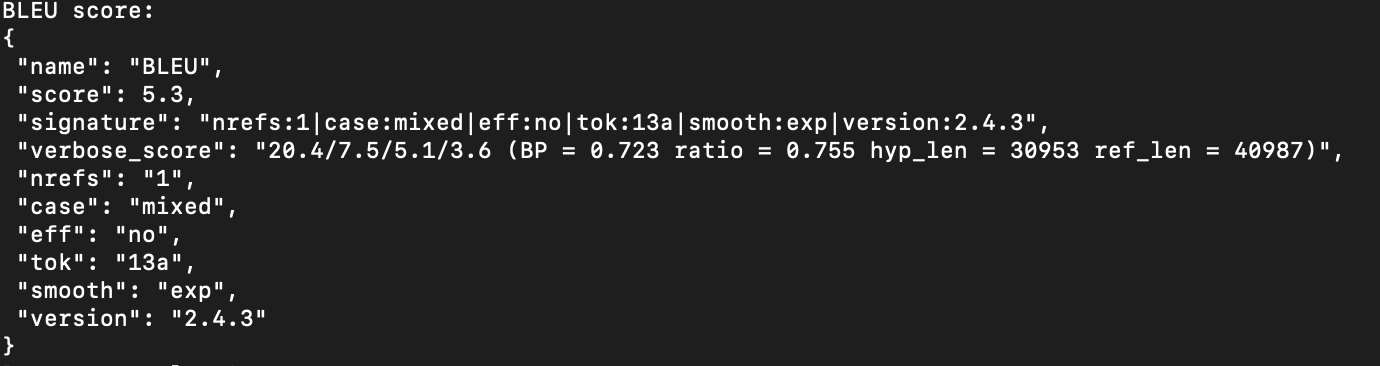

### Bonus. Manual analysis (2 pt)

Even though automatic metrics are widely used to evaluate machine translation quality, they cannot show what kinds of errors the models make. A number provided by an automatic metric is not enough to make informed decisions about how to improve your model. It is always important to have an idea of what exactly your model is doing right and wrong.

That is why, in this task, you will manually evaluate your model's performance on the external test set (`/gpfs/space/projects/transformers2023/data/test-set/`) that you translated in task 6.

**Task.** Analyse 5 randomly selected sentences from the translated test set. For each of the 5, report:

1. Sentence ID (line number)
2. Source sentence (in Estonian)
3. Reference translation
4. Machine translation (by your model)
5. Description of errors in the translation. You may use any system that seems reasonable to you. For instance, you could classify errors as "word order errors", "untranslated words in source", etc. A description of a sentence can be something like "it tried to represent meaning, but made grammatical errors" or "hypothesis is fluent, but does not represent meaning correctly".

**Hint.** A convenient tool for comparing translations to references: [https://mateo.ivdnt.org/Visualize](https://mateo.ivdnt.org/Visualize)

In [ ]:
 #!/bin/bash

SRC_FILE="sentencepiece/test-src.et"
HYP_FILE="hypothesis.en"
REF_FILE="sentencepiece/test-ref.en"

if [ ! -f "$SRC_FILE" ] || [ ! -f "$HYP_FILE" ] || [ ! -f "$REF_FILE" ]; then
    echo "Error: One or more files not found!"
    exit 1
fi

total_lines=$(wc -l < "$SRC_FILE")

random_lines=$(shuf -i 1-$total_lines -n 5)

echo -e "Line\tOriginal (Estonian)\tHypothesis (Model Translation)\tActual Translation (Reference)"


for line_num in $random_lines; do
    original=$(sed -n "${line_num}p" "$SRC_FILE")
    hypothesis=$(sed -n "${line_num}p" "$HYP_FILE")
    reference=$(sed -n "${line_num}p" "$REF_FILE")
    echo -e "$line_num\t$original\t$hypothesis\t$reference"
done

**Your answer:** couldn't finalize the translation report completely (some issues with processing + I don't know Estonian), but my idea was to translate with few services the first sentence, to have additional possible options how it can look like not just from reference to have more context.

In general I could't finish this task but it was interesting to do such comparison and try to work with new languages;)